## Car Data

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, one can quickly find out the market value of their car. We have access to historical data: technical specifications, trim versions, and prices. We need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# import libraries

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
# import data

df = pd.read_csv('/datasets/car_data.csv')

First we will run a variety of small pieces of code just to get an idea on what our data looks like and what we might need to do in order to treat it.

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df.corr()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Mileage,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Looking over our data we see that one thing we might wish to change is the format of our column names if we desire.

In [8]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'mileage', 
              'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_pictures', 'postal_code', 
              'last_seen']

Our date values are also marked as strings, we should convert them to datetime if we wished to use them. However, the date data may result in errors and is not useful for prediction so it will be dropped instead, along with the postal code.

In [9]:
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen'], axis=1)

We also can see in our data that the registration year ranges from 1000 to 9999, which is quite strange. We should instead compress those dates to ones that are plausible. Our first quartile is 1999 and our third quartile is 2008, we could choose to fill these data points with the IQR that would range from 1986 to 2022, but we should note that our data is from 2016.

We should see just how many values are in those points with strange registration years. We can define strange registration years as anything that is either an outlier on the lower end (meaning anything with a registration before 1986) or is above the year of our data crawling (which would be a registration after 2016).

In [10]:
df.query('registration_year < 1986 or registration_year > 2016')

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,number_pictures
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,0
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,0
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,0
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,0
28,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354253,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,0
354286,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes,0
354289,5000,NaN,2017,manual,120,other,150000,7,NaN,citroen,yes,0
354302,5990,bus,1984,auto,0,other,70000,4,petrol,chevrolet,NaN,0


We see that this is resulting in about 5% of our data set being flagged with an outlier date. It might be something that would have an effect on our model. The data with a registration year after 2016 seems to be an error, so it will be removed. But we should then consider what to do with the data from earlier years.

Older cars have a different sort of valuation than what we would expect from most sales, so we probably will get a better model if we decide to have a cutoff date for cars that are likely to be valued on similar metrics. A car that is sufficiently old will not be valued based on its performance, mileage,or repair status but more on its collector's value. Since our outlier date is 1986, we can use that.

In [11]:
df = df.query('registration_year >= 1986 and registration_year <= 2016')

We also see some strange values in our horsepower column. We can alter our cutoffs but there should be a cutoff where we can rightfully assume that the horsepower data has an error. 

In [12]:
df.groupby(['vehicle_type', 'fuel_type'])['power'].mean()

vehicle_type  fuel_type
bus           cng           97.125523
              electric      60.000000
              gasoline     112.840575
              hybrid       123.800000
              lpg          123.888676
              other         53.375000
              petrol       113.568636
convertible   cng           95.666667
              electric      50.333333
              gasoline     128.341528
              lpg          144.783333
              other        114.000000
              petrol       134.435976
coupe         cng          126.500000
              electric     135.000000
              gasoline     168.388002
              hybrid       111.375000
              lpg          178.215488
              other         36.666667
              petrol       155.169588
other         cng           99.615385
              electric       6.083333
              gasoline      82.902906
              hybrid       136.000000
              lpg          132.153846
              other       

By grouping our data by the vehicle type and fuel type, that gives us a good idea of what sort of horsepower that we should expect from our vehicles. Generally speaking, there is a wide range so we should not place our cutoffs too close to the mean, but we should establish some cutoff points that account for errors.

We will choose to fill out any data where the horsepower is either greater than 300 or lower than 50 with the mean horsepower, grouping our data by car brand, vehicle type, and fuel type. We will do this in a function.

In [13]:
def fill_power(data, lower, upper, categories):
    df['power'] = np.where((df['power'] == 0), df.groupby(categories)['power']
                       .transform('mean').round(0), df['power'])
    df['power'] = np.where((df['power'] > upper), df.groupby(categories)['power']
                       .transform('mean').round(0), df['power'])
    df['power'] = np.where((df['power'] < lower), df.groupby(categories)['power']
                       .transform('mean').round(0), df['power'])
    df['power'] = np.where((df['power'].isna()), df.groupby(categories)['power']
                       .transform('mean').round(0), df['power'])

In [14]:
fill_power(df, 50, 300, ['brand', 'vehicle_type', 'fuel_type'])

In [15]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_pictures
count,333635.000000,333635.000000,318938.000000,333635.000000,333635.00000,333635.0
mean,4448.074977,2002.994536,118.890242,128686.034139,5.78368,0.0
std,4528.639461,5.823415,48.186172,37294.686219,3.70459,0.0
min,0.000000,1986.000000,0.000000,5000.000000,0.00000,0.0
25%,1099.000000,1999.000000,76.000000,125000.000000,3.00000,0.0
50%,2750.000000,2003.000000,111.000000,150000.000000,6.00000,0.0
75%,6499.000000,2007.000000,150.000000,150000.000000,9.00000,0.0
max,20000.000000,2016.000000,2018.000000,150000.000000,12.00000,0.0


This does fill out many of our data points but since it requires that we know the car's vehicle type, fuel type, and brand it does mean that we might still be missing data points in our power column. As such, we can repeat this same process with different groupby categories, so that we can get as accurate data as possible.

In [16]:
fill_power(df, 50, 300, ['vehicle_type', 'fuel_type'])

In [17]:
fill_power(df, 50, 300, ['brand', 'vehicle_type'])

In [18]:
fill_power(df, 50, 300, ['brand', 'fuel_type'])

In [19]:
df.isna().sum()

price                     0
vehicle_type          21925
registration_year         0
gearbox               16653
power                  6139
model                 16330
mileage                   0
registration_month        0
fuel_type             25936
brand                     0
not_repaired          62662
number_pictures           0
dtype: int64

We still see that there are missing values in here after doing our two-predictor model. In this instance, we will need to go for single-group fills. The brand is less relevant than the vehicle and fuel types so that will be the last one that we use to fill, but since brand is not missing any data points it will for certain fill out the rest of our missing data points.

In [20]:
fill_power(df, 50, 300, ['vehicle_type'])

In [21]:
fill_power(df, 50, 300, ['fuel_type'])

In [22]:
fill_power(df, 50, 300, ['brand'])

In [23]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_pictures
count,333635.000000,333635.000000,333635.000000,333635.000000,333635.00000,333635.0
mean,4448.074977,2002.994536,118.754028,128686.034139,5.78368,0.0
std,4528.639461,5.823415,46.988067,37294.686219,3.70459,0.0
min,0.000000,1986.000000,50.000000,5000.000000,0.00000,0.0
25%,1099.000000,1999.000000,80.000000,125000.000000,3.00000,0.0
50%,2750.000000,2003.000000,110.000000,150000.000000,6.00000,0.0
75%,6499.000000,2007.000000,149.000000,150000.000000,9.00000,0.0
max,20000.000000,2016.000000,300.000000,150000.000000,12.00000,0.0


Here we see that we, no longer have those extreme data points in our data's power. Our mean and standard deviation have not dramatically changed since our initial run where we grouped our data by three predictors, which means that our data is still rather similar to it was before.

We should next check for other null values.

In [24]:
df.isna().sum()

price                     0
vehicle_type          21925
registration_year         0
gearbox               16653
power                     0
model                 16330
mileage                   0
registration_month        0
fuel_type             25936
brand                     0
not_repaired          62662
number_pictures           0
dtype: int64

Of our data will missing values, all of the variables appear to be relevant. This is troublesome since dropping them will not be good for our model. We don't seem to have predictors that will be useful for predicting these other models. If we had a specific model name or product ID, we could fill the values in based on that, but we do not have a clear one at the moment. We can try and see if there is a direct correlation between our variables. In order to do this, we will need to modify our data to numeric if possible.

In [25]:
df.corr()

,price,registration_year,power,mileage,registration_month,number_pictures
price,1.000000,0.563341,0.488810,-0.345175,0.107500,NaN
registration_year,0.563341,1.000000,0.130873,-0.340790,0.055830,NaN
power,0.488810,0.130873,1.000000,0.088727,0.047312,NaN
mileage,-0.345175,-0.340790,0.088727,1.000000,0.000456,NaN
registration_month,0.107500,0.055830,0.047312,0.000456,1.000000,NaN
number_pictures,NaN,NaN,NaN,NaN,NaN,NaN


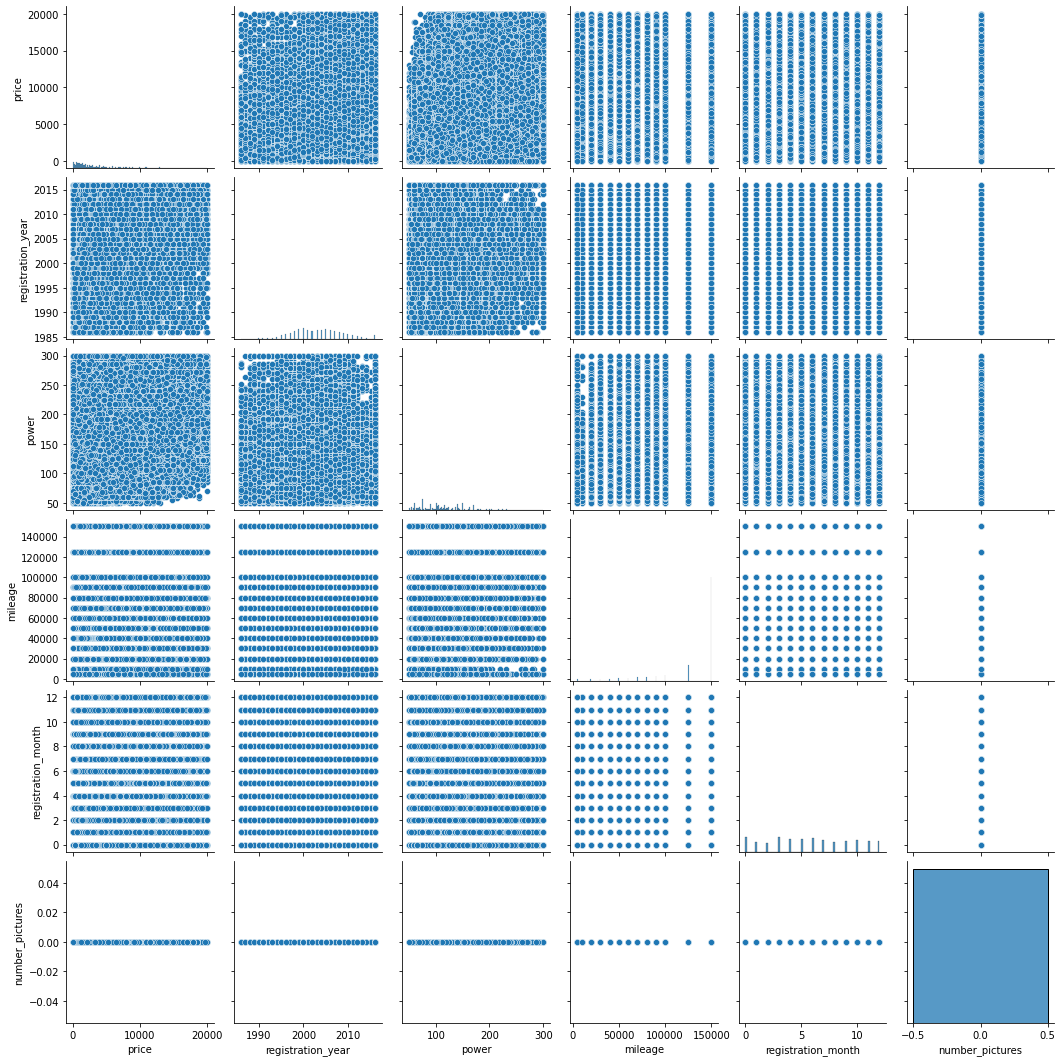

In [26]:
sns.pairplot(df);

We see here that there does not appear to be a strong correlation between our data points that will let us fill out our data with reliably predicted data. Instead, we will use a value of 'unknown' for those points.

In [27]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')
df['gearbox'] = df['gearbox'].fillna('unknown')
df['fuel_type'] = df['fuel_type'].fillna('unknown')
df['not_repaired'] = df['not_repaired'].fillna('unknown')

Before we progress with analysis, it could be useful to encode our data. We can try OHE and an ordinal encoding.

In [28]:
# ohe

df_ohe = df.drop(['model', 'brand'], axis=1)
df_ohe = pd.get_dummies(df_ohe, drop_first = True)

## ordinal encoding data 

# create a list of categorical features to encode

categorical_features = ['vehicle_type', 'model', 'gearbox', 'fuel_type', 'brand', 'not_repaired']

df_ordinal = df.copy()

df_ordinal[categorical_features] = OrdinalEncoder().fit_transform(df[categorical_features])

In [29]:
df_ordinal

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,number_pictures
0,480,7.0,1993,1.0,94.0,116.0,150000,0,6.0,38.0,1.0,0
1,18300,2.0,2011,1.0,190.0,225.0,125000,5,2.0,1.0,2.0,0
2,9800,6.0,2004,0.0,163.0,117.0,125000,8,2.0,14.0,1.0,0
3,1500,5.0,2001,1.0,75.0,116.0,150000,6,6.0,38.0,0.0,0
4,3600,5.0,2008,1.0,69.0,101.0,90000,7,2.0,31.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,7.0,2005,1.0,112.0,78.0,150000,7,6.0,22.0,2.0,0
354365,2200,7.0,2005,2.0,152.0,225.0,20000,1,7.0,33.0,1.0,0
354366,1199,1.0,2000,0.0,101.0,106.0,125000,3,6.0,32.0,0.0,0
354367,9200,0.0,1996,1.0,102.0,221.0,150000,3,2.0,38.0,0.0,0


## Model training

In [30]:
# split data into training, validation, and test sets for both encoded data sets and the full data

index_train_valid, index_test = train_test_split(df.index, test_size = 0.2, random_state = 12345)
index_train, index_valid = train_test_split(index_train_valid, test_size = 0.25, random_state = 12345)

train_ord = df_ordinal.loc[index_train]
valid_ord = df_ordinal.loc[index_valid]
test_ord = df_ordinal.loc[index_test]

train_ohe = df_ohe.loc[index_train]
valid_ohe = df_ohe.loc[index_valid]
test_ohe = df_ohe.loc[index_test]

df_train = df.loc[index_train]
df_valid = df.loc[index_valid]
df_test = df.loc[index_test]

In [31]:
# create function to calculate rmse

def rmse(target,predictions): 
    return mean_squared_error(target, predictions) ** 0.5

In [32]:
# test against a dummy model

pred_mean = np.ones(df_test['price'].shape) * df_test['price'].mean()
print("Dummy model RMSE:", rmse(df_test['price'], pred_mean))

Dummy model RMSE: 4549.261729858943


### Testing Regressions

We will try out a few regression models first things first. In order to just get a general idea of their relative usefulness, the initial models will be done without modifying any of our hyperparameters, though we will keep a consistent random state.

In [33]:
%%time

# linear regression

lin_reg = LinearRegression()

lin_reg.fit(train_ord.iloc[:, 1:], train_ord.iloc[:, 0])

CPU times: user 54.3 ms, sys: 36.2 ms, total: 90.6 ms
Wall time: 61.1 ms


LinearRegression()

In [34]:
%%time

# create prediction

lr_pred = lin_reg.predict(valid_ord.iloc[:, 1:])

CPU times: user 21.3 ms, sys: 4.05 ms, total: 25.4 ms
Wall time: 7.51 ms


In [35]:
# check RMSE

rmse(valid_ord['price'], lr_pred)

2841.520094993986

In [36]:
%%time

# perform the same tests for random forest

rf = RandomForestRegressor(random_state = 12345)

rf.fit(train_ord.iloc[:, 1:], train_ord.iloc[:, 0])

CPU times: user 55.1 s, sys: 952 ms, total: 56 s
Wall time: 56 s


RandomForestRegressor(random_state=12345)

In [37]:
%%time

rf_pred = rf.predict(valid_ord.iloc[:, 1:])

CPU times: user 3.03 s, sys: 3.98 ms, total: 3.03 s
Wall time: 3.04 s


In [38]:
rmse(valid_ord['price'], rf_pred)

1709.0367816537403

In [39]:
%%time

# test cat boost

cb = CatBoostRegressor(iterations = 500, cat_features = categorical_features, random_state = 12345)

cb.fit(df_train.iloc[:, 1:], df_train.iloc[:, 0], eval_set=(df_valid.iloc[:, 1:], df_valid.iloc[:, 0]))

Learning rate set to 0.178586
0:	learn: 4002.2500447	test: 4032.2554151	best: 4032.2554151 (0)	total: 384ms	remaining: 3m 11s
1:	learn: 3603.7236602	test: 3629.8448263	best: 3629.8448263 (1)	total: 724ms	remaining: 3m
2:	learn: 3269.3284725	test: 3295.1895603	best: 3295.1895603 (2)	total: 938ms	remaining: 2m 35s
3:	learn: 3010.5543440	test: 3034.6145187	best: 3034.6145187 (3)	total: 1.13s	remaining: 2m 20s
4:	learn: 2802.9269751	test: 2824.6704713	best: 2824.6704713 (4)	total: 1.41s	remaining: 2m 19s
5:	learn: 2641.5308356	test: 2662.6677102	best: 2662.6677102 (5)	total: 1.65s	remaining: 2m 16s
6:	learn: 2515.7633592	test: 2533.4052967	best: 2533.4052967 (6)	total: 1.86s	remaining: 2m 11s
7:	learn: 2406.9535196	test: 2423.6536987	best: 2423.6536987 (7)	total: 2.14s	remaining: 2m 11s
8:	learn: 2323.4130467	test: 2338.2732223	best: 2338.2732223 (8)	total: 2.37s	remaining: 2m 9s
9:	learn: 2253.7990920	test: 2267.1403810	best: 2267.1403810 (9)	total: 2.67s	remaining: 2m 10s
10:	learn: 2200

In [59]:
%%time

cb_pred = cb.predict(df_valid.iloc[:, 1:])

CPU times: user 367 ms, sys: 4.03 ms, total: 371 ms
Wall time: 381 ms


In [60]:
rmse(df_valid['price'], cb_pred)

1693.1729506135416

In [41]:
%%time 

# test light GBM

lgbm = LGBMRegressor(random_state = 12345)
lgbm.fit(train_ord.iloc[:, 1:], train_ord.iloc[:, 0], eval_set=(valid_ord.iloc[:, 1:], valid_ord.iloc[:, 0]), 
         categorical_feature = categorical_features)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'not_repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 1.78401e+07
[2]	valid_0's l2: 1.5536e+07
[3]	valid_0's l2: 1.36057e+07
[4]	valid_0's l2: 1.20144e+07
[5]	valid_0's l2: 1.07171e+07
[6]	valid_0's l2: 9.59909e+06
[7]	valid_0's l2: 8.65904e+06
[8]	valid_0's l2: 7.87946e+06
[9]	valid_0's l2: 7.23045e+06
[10]	valid_0's l2: 6.67523e+06
[11]	valid_0's l2: 6.19854e+06
[12]	valid_0's l2: 5.80131e+06
[13]	valid_0's l2: 5.46196e+06
[14]	valid_0's l2: 5.16332e+06
[15]	valid_0's l2: 4.90938e+06
[16]	valid_0's l2: 4.69338e+06
[17]	valid_0's l2: 4.50969e+06
[18]	valid_0's l2: 4.35293e+06
[19]	valid_0's l2: 4.21156e+06
[20]	valid_0's l2: 4.08123e+06
[21]	valid_0's l2: 3.97536e+06
[22]	valid_0's l2: 3.88477e+06
[23]	valid_0's l2: 3.8022e+06
[24]	valid_0's l2: 3.73019e+06
[25]	valid_0's l2: 3.66831e+06
[26]	valid_0's l2: 3.60738e+06
[27]	valid_0's l2: 3.55857e+06
[28]	valid_0's l2: 3.50755e+06
[29]	valid_0's l2: 3.4699e+06
[30]	valid_0's l2: 3.43448e+06
[31]	valid_0's l2: 3.40361e+06
[32]	valid_0's l2: 3.37362e+06
[33]	valid_0's l2: 3

LGBMRegressor(random_state=12345)

In [42]:
%%time

lgbm_pred = lgbm.predict(valid_ord.iloc[:, 1:])

CPU times: user 647 ms, sys: 11.3 ms, total: 659 ms
Wall time: 690 ms


In [43]:
rmse(valid_ord['price'], lgbm_pred)

1708.8389996937217

In [44]:
%%time

# test XGB

xgb = XGBRegressor(random_state = 12345)
xgb.fit(train_ohe.iloc[:, 1:], train_ohe.iloc[:, 0])

CPU times: user 2min 16s, sys: 941 ms, total: 2min 17s
Wall time: 2min 18s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
%%time

rmse_pred = xgb.predict(valid_ohe.iloc[:, 1:])

CPU times: user 251 ms, sys: 7.61 ms, total: 259 ms
Wall time: 247 ms


In [46]:
rmse(valid_ohe['price'], rmse_pred)

1899.1767686018004

We can see that from the looks of things the catboost is the most accurate regression, but the slowest. The LGBM is the fastest and the second most accurate. The XGBM is not the most accurate nor is it the fastest, and neither is the random forest, but that does not mean we can or should discount them, as we will want to do some hyperparameter tuning. In particular, the random forest has accuracy on par with the cat boost regressor with a shorter runtime.

## Model analysis

In order to find the best model, we will need to adjust our hyperparameters and do a grid search across our models. We will need to tune our parameters for our random forest, LGBM, and XGB models. First, we should establish parameter grids.

In [47]:
# parameter grids

# random forest

rf_params = {
    'n_estimators': (100, 150, 200),
    'min_samples_split' : (2, 5, 10, 15)
}

# lgbm

lgbm_params = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'learning_rate' : [0.05, 0.1, 0.15, 0.25],
    'n_estimators': (100, 150, 200)
}

# xgb

xgb_params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'learning_rate' : [0.05, 0.1, 0.15, 0.25],
    'n_estimators': (100, 150, 200)
}

### Tuning Random Forest

In [ ]:
%%time

rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params, verbose=3)
rf_grid.fit(train_ohe.iloc[:, 1:], train_ohe.iloc[:, 0])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..........min_samples_split=2, n_estimators=100; total time=  49.3s
[CV 2/5] END ..........min_samples_split=2, n_estimators=100; total time=  48.5s
[CV 3/5] END ..........min_samples_split=2, n_estimators=100; total time=  49.2s
[CV 4/5] END ..........min_samples_split=2, n_estimators=100; total time=  48.5s
[CV 5/5] END ..........min_samples_split=2, n_estimators=100; total time=  50.0s
[CV 1/5] END ..........min_samples_split=2, n_estimators=150; total time= 1.2min
[CV 2/5] END ..........min_samples_split=2, n_estimators=150; total time= 1.3min
[CV 3/5] END ..........min_samples_split=2, n_estimators=150; total time= 1.3min
[CV 4/5] END ..........min_samples_split=2, n_estimators=150; total time= 1.3min
[CV 5/5] END ..........min_samples_split=2, n_estimators=150; total time= 1.3min


In [ ]:
rf_grid.cv_results_

In [ ]:
print(rf_grid.best_params_)
rf_grid.best_estimator_.predict(test_ord.iloc[:, 1:])

We see the grid test show that our best parameters for random forest are with a max depth of 15 and 200 estimators.

In [47]:
%%time

rf = RandomForestRegressor(max_depth = 15, n_estimators = 200, random_state = 12345)

rf.fit(train_ohe.iloc[:, 1:], train_ohe.iloc[:, 0])

CPU times: user 1min 23s, sys: 281 ms, total: 1min 23s
Wall time: 1min 23s


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=12345)

In [48]:
%%time

rf_pred = rf.predict(valid_ohe.iloc[:, 1:])

CPU times: user 2.56 s, sys: 11.8 ms, total: 2.57 s
Wall time: 2.57 s


In [49]:
rmse(valid_ohe['price'], rf_pred)

1909.2391873112967

### Tuning LGBM

In [48]:
%%time

lgbm_grid = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, verbose=3)
lgbm_grid.fit(train_ord.iloc[:, 1:], train_ord.iloc[:, 0], eval_set=(valid_ord.iloc[:, 1:], valid_ord.iloc[:, 0]))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[1]	valid_0's l2: 1.92676e+07
[2]	valid_0's l2: 1.79886e+07
[3]	valid_0's l2: 1.6832e+07
[4]	valid_0's l2: 1.57881e+07
[5]	valid_0's l2: 1.48262e+07
[6]	valid_0's l2: 1.39642e+07
[7]	valid_0's l2: 1.31781e+07
[8]	valid_0's l2: 1.24511e+07
[9]	valid_0's l2: 1.17932e+07
[10]	valid_0's l2: 1.11909e+07
[11]	valid_0's l2: 1.06409e+07
[12]	valid_0's l2: 1.01402e+07
[13]	valid_0's l2: 9.67604e+06
[14]	valid_0's l2: 9.25804e+06
[15]	valid_0's l2: 8.8582e+06
[16]	valid_0's l2: 8.49577e+06
[17]	valid_0's l2: 8.17702e+06
[18]	valid_0's l2: 7.87314e+06
[19]	valid_0's l2: 7.59287e+06
[20]	valid_0's l2: 7.33514e+06
[21]	valid_0's l2: 7.10009e+06
[22]	valid_0's l2: 6.88248e+06
[23]	valid_0's l2: 6.68638e+06
[24]	valid_0's l2: 6.50375e+06
[25]	valid_0's l2: 6.33423e+06
[26]	valid_0's l2: 6.17696e+06
[27]	valid_0's l2: 6.02791e+06
[28]	valid_0's l2: 5.88769e+06
[29]	valid_0's l2: 5.75928e+06
[30]	valid_0's l2: 5.6413e+06
[31]	valid_0's l2: 5

GridSearchCV(estimator=LGBMRegressor(random_state=12345),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'learning_rate': [0.05, 0.1, 0.15, 0.25],
                         'n_estimators': (100, 150, 200)},
             verbose=3)

In [49]:
lgbm_grid.cv_results_

{'mean_fit_time': array([ 45.51194463,   8.71704283,  10.59867091,   5.56244335,
          7.27575746,   9.39796987,   6.03699393,  96.0427536 ,
         56.19720645,  11.88212419,   8.96025624,   9.63646212,
         52.35582986, 445.67711663, 139.4361289 , 106.13437104,
        229.81391411,  61.6164844 ,  16.8430388 ,  37.29668732,
        134.51722279,  61.35671859,  58.69319801,  56.65431643,
          9.19643326,  11.1763413 ,  15.77972531,   9.87491827,
         12.37955341, 253.37727351,  25.85353279,  12.03798962,
         22.10039592,  21.89558454,  17.05704775,  14.11588778]),
 'std_fit_time': array([ 78.52925263,   0.85038263,   0.44598571,   0.35523825,
          0.41209691,   0.42388665,   1.61296641,  39.44821146,
         21.90819037,   8.74432907,   2.57815383,   2.75473518,
         30.44734479, 191.47810114,  91.37379321, 108.57432697,
        114.56177506,  11.6944861 ,   2.03808292,   6.95444792,
         55.66372111,  25.28103111,  45.21319418,   8.73144802,
     

In [50]:
print(lgbm_grid.best_params_)
lgbm_grid.best_estimator_.predict(test_ord.iloc[:, 1:])

{'boosting_type': 'gbdt', 'learning_rate': 0.25, 'n_estimators': 200}


array([ 4368.63224466,  2111.70258739,   565.04242291, ...,
        5874.08566273,  2442.07403167, 12046.98360574])

In [50]:
lgbm_reg = LGBMRegressor(boosting_type = 'gbdt', learning_rate = 0.25, n_estimators = 200, random_state = 12345)

lgbm_reg.fit(train_ord.iloc[:, 1:], train_ord.iloc[:, 0], eval_set=(valid_ord.iloc[:, 1:], valid_ord.iloc[:, 0]), 
         categorical_feature = categorical_features)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'not_repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 1.41393e+07
[2]	valid_0's l2: 1.02377e+07
[3]	valid_0's l2: 7.85881e+06
[4]	valid_0's l2: 6.3384e+06
[5]	valid_0's l2: 5.40057e+06
[6]	valid_0's l2: 4.74609e+06
[7]	valid_0's l2: 4.32523e+06
[8]	valid_0's l2: 4.02577e+06
[9]	valid_0's l2: 3.8229e+06
[10]	valid_0's l2: 3.6681e+06
[11]	valid_0's l2: 3.54757e+06
[12]	valid_0's l2: 3.45783e+06
[13]	valid_0's l2: 3.39202e+06
[14]	valid_0's l2: 3.34036e+06
[15]	valid_0's l2: 3.2984e+06
[16]	valid_0's l2: 3.26211e+06
[17]	valid_0's l2: 3.2352e+06
[18]	valid_0's l2: 3.2027e+06
[19]	valid_0's l2: 3.17934e+06
[20]	valid_0's l2: 3.15771e+06
[21]	valid_0's l2: 3.14265e+06
[22]	valid_0's l2: 3.13077e+06
[23]	valid_0's l2: 3.11164e+06
[24]	valid_0's l2: 3.09773e+06
[25]	valid_0's l2: 3.08273e+06
[26]	valid_0's l2: 3.0722e+06
[27]	valid_0's l2: 3.05857e+06
[28]	valid_0's l2: 3.04985e+06
[29]	valid_0's l2: 3.04234e+06
[30]	valid_0's l2: 3.03713e+06
[31]	valid_0's l2: 3.02839e+06
[32]	valid_0's l2: 3.01833e+06
[33]	valid_0's l2: 3.008

LGBMRegressor(learning_rate=0.25, n_estimators=200, random_state=12345)

In [54]:
%%time

lgbm_pred = lgbm_reg.predict(valid_ord.iloc[:, 1:])

CPU times: user 860 ms, sys: 0 ns, total: 860 ms
Wall time: 778 ms


In [52]:
rmse(valid_ord['price'], lgbm_pred)

1664.0797591046512

### Tuning XGB

In [43]:
%%time

xgb_grid = GridSearchCV(estimator = xgb, param_grid = xgb_params, verbose=3)
xgb_grid.fit(train_ohe.iloc[:, 1:], train_ohe.iloc[:, 0])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END booster=gbtree, learning_rate=0.05, n_estimators=100; total time=  48.3s
[CV 2/5] END booster=gbtree, learning_rate=0.05, n_estimators=100; total time=  47.7s
[CV 3/5] END booster=gbtree, learning_rate=0.05, n_estimators=100; total time=  46.7s
[CV 4/5] END booster=gbtree, learning_rate=0.05, n_estimators=100; total time=  49.0s
[CV 5/5] END booster=gbtree, learning_rate=0.05, n_estimators=100; total time=  54.8s
[CV 1/5] END booster=gbtree, learning_rate=0.05, n_estimators=150; total time= 1.2min
[CV 2/5] END booster=gbtree, learning_rate=0.05, n_estimators=150; total time= 1.1min
[CV 3/5] END booster=gbtree, learning_rate=0.05, n_estimators=150; total time= 1.2min
[CV 4/5] END booster=gbtree, learning_rate=0.05, n_estimators=150; total time= 1.1min
[CV 5/5] END booster=gbtree, learning_rate=0.05, n_estimators=150; total time= 1.2min
[CV 1/5] END booster=gbtree, learning_rate=0.05, n_estimators=200; total time=

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=12345, reg_alpha=0,
                                    reg_lambda=1, scale_pos_weight=1,
                                    subsample=1, tree_method='exact',
                   

In [44]:
xgb_grid.cv_results_

{'mean_fit_time': array([ 49.12560573,  69.05714741,  94.7057466 ,  50.27049522,
         91.63179946,  93.49778032,  46.11635151,  70.23732033,
         92.83313704,  45.83148651,  67.92394314,  90.89061174,
          8.70174179,  12.79555907,  16.80278106,   8.46504602,
         12.68508868,  16.7210362 ,   8.72421465,  13.45086055,
         16.81574149,   8.38400431,  12.52156463,  16.78220835,
        198.50831132, 413.41596308, 723.35994968, 189.42306943,
        385.90927305, 683.57879677, 187.18919315, 404.81922531,
        655.29061065, 187.5930944 , 394.11626339, 650.29989133]),
 'std_fit_time': array([2.85761971e+00, 1.19879939e+00, 3.58904841e+00, 4.52496808e+00,
        4.13895178e+01, 4.07984829e+00, 1.02513344e+00, 2.78980662e+00,
        3.42957071e+00, 1.33434324e+00, 2.90003853e+00, 2.19112991e+00,
        3.02611206e-01, 2.92114640e-01, 5.04757344e-01, 1.00631764e-01,
        3.41180502e-01, 1.63944691e-01, 4.49910758e-01, 1.32550001e+00,
        4.27141707e-01, 3.610

In [45]:
print(xgb_grid.best_params_)
xgb_grid.best_estimator_.predict(test_ohe.iloc[:, 1:])

{'booster': 'gbtree', 'learning_rate': 0.25, 'n_estimators': 200}


array([ 3263.902  ,  2542.0918 ,   616.21124, ...,  5222.406  ,
        1639.5621 , 12037.099  ], dtype=float32)

In [56]:
xgb_reg = XGBRegressor(booster = 'gbtree', learning_rate = 0.25, random_state = 12345)
xgb_reg.fit(train_ohe.iloc[:, 1:], train_ohe.iloc[:, 0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.25, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
%%time

xgb_pred = xgb_reg.predict(test_ohe.iloc[:, 1:])

CPU times: user 283 ms, sys: 0 ns, total: 283 ms
Wall time: 284 ms


In [58]:
rmse(test_ohe['price'], xgb_pred)

1886.1358255274768

Currently our best models on the validation set are the catboost and LGBM models. We will check both of them against the test set.

In [61]:
%%time

cb_pred = cb.predict(df_test.iloc[:, 1:])

CPU times: user 367 ms, sys: 0 ns, total: 367 ms
Wall time: 378 ms


In [62]:
%%time

lgbm_pred = lgbm_reg.predict(test_ord.iloc[:, 1:])

CPU times: user 787 ms, sys: 0 ns, total: 787 ms
Wall time: 759 ms


In [63]:
print("Cat Boost Model RMSE:", rmse(df_test['price'], lgbm_pred))
print("Tuned LGBM Model RMSE:", rmse(test_ord['price'], cb_pred))

Cat Boost Model RMSE: 1635.9060471682608
Tuned LGBM Model RMSE: 1670.7128619562259


As a whole, it did not appear that the tuning yielded very fruitful results. While the models are more accurate, they do not appear to have been made significantly more accurate as a result, and the process of performing our grid search takes quite a while.

The tuned LGBM model had a better performance when predicting on the validation set but it had a higher RMSE against the test set. This would suggest that it is not necessarily more accurate than the cat boost model, but it has a longer compiling time.

Thus, it would seem that our cat boost model is our best option.

## Conclusion

In conclusion, after cleaning our data we tried out some regressions using the default parameters in our tests, checking for both time and accuracy. We further implemented model tuning for some of them to find the best model and determined that the cat boost was the one with the best accuracy and speed.

### Checklist

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed